<a href="https://colab.research.google.com/github/niruthikka24/Computer-Vision-Labs/blob/main/Canny_Edge_Detection/Step_by_Step_Approach_to_Canny_Edge_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

In [ ]:
def convert_to_grayscale(image):
  grayscale_image = np.zeros((image.shape[0], image.shape[1]), np.uint8)
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      r, g, b = image[x][y]
      #weighted contributions of red, green and blue channels
      gray_value = 0.299 * r + 0.587 * g + 0.114 * b
      grayscale_image[x][y] = gray_value
  #ensure that the value is in the valid range [0, 255] for an 8-bit image
  return grayscale_image

In [ ]:
up = files.upload()

Saving lena.png to lena.png


In [ ]:
img = Image.open('lena.png')
img = np.array(img)

In [ ]:
img.shape

(512, 512, 3)

In [ ]:
gray_img = convert_to_grayscale(img)
# Image.fromarray(gray_img.astype(np.uint8)).save('grayscale_lena.png')

The formula to calculate the Gaussian kernel at an arbitrary point K(x,y) is as follows:

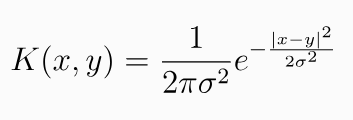

In [ ]:
'''
Same as: K(x, y) = (1 / (2 * pi * sigma^2)) * exp(-(x^2 + y^2) / (2 * sigma^2))
In order to create a Gaussian kernel matrix
we must calculate the value of the Gaussian kernel for every point in the given dataset.
'''
def gaussian_kernel_old(kernel_size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - kernel_size//2)**2 + (y - kernel_size//2)**2) / (2 * sigma**2)),
         (kernel_size, kernel_size)
         )
    normal = kernel / np.sum(kernel)
    return normal

kernel_size = 5
sigma = 1.0
gaussian_matrix = gaussian_kernel_old(kernel_size, sigma)
print(gaussian_matrix)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


In [ ]:
def gaussian_kernel(size, sigma=1):
  size = int(size) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  print(x)
  print(y)
  normal = 1 / (2.0 * np.pi * sigma**2)
  g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  return g

In [ ]:
print(gaussian_kernel(5))

[[-2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1]
 [ 0  0  0  0  0]
 [ 1  1  1  1  1]
 [ 2  2  2  2  2]]
[[-2 -1  0  1  2]
 [-2 -1  0  1  2]
 [-2 -1  0  1  2]
 [-2 -1  0  1  2]
 [-2 -1  0  1  2]]
[[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]


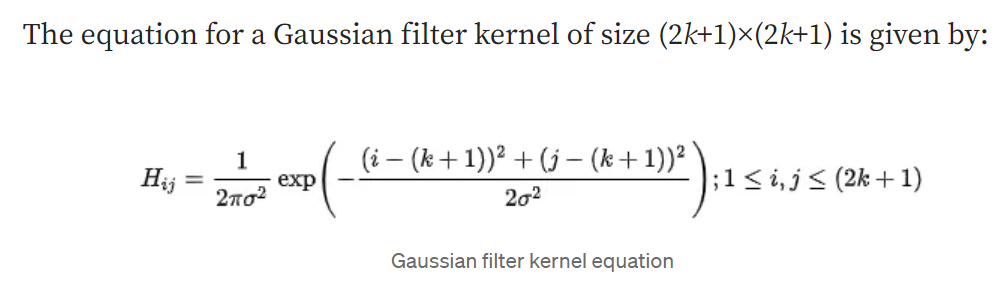

In [ ]:
'''
K(x, y) = (1 / (2 * pi * sigma^2)) * exp(-((i-k-1)^2 + (j-k-1)^2) / (2 * sigma^2)), where i,j range from 1 to size
and k = size//2
'''

def my_gaussian_kernel(size, sigma=1):
  x, y = np.mgrid[1:size+1, 1:size+1]
  # print(x)
  # print(y)
  k = size//2
  normal = 1 / (2.0 * np.pi * sigma**2)
  expterm = np.exp(-(((x-k-1)**2 + (y-k-1)**2) / (2.0*sigma**2)))
  gaussian = normal * expterm
  return gaussian

In [ ]:
gaussian = my_gaussian_kernel(5)
print(gaussian)

[[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]


In [ ]:
'''
For output to be in same dimension as input (i.e. same convolution) we need to pad the image
Here we pad the image with 0s
The size of padding is given by (k-1)/2 where k is the size of kernel
'''
def convolution(image, kernel, average=False):
  image_row, image_col = image.shape
  kernel_row, kernel_col = kernel.shape

  output = np.zeros(image.shape)

  pad_height = int((kernel_row - 1) / 2)
  pad_width = int((kernel_col - 1) / 2)
  padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
  padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

  for row in range(image_row):
    for col in range(image_col):
        output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])

  #to apply blurring/smoothing effect divide output by the total no. of pixels in kernel
  if average:
    output[row, col] /= kernel.shape[0] * kernel.shape[1]

  return output

In [ ]:
'''
As you have noticed, once we use a larger filter/kernel there is a black border appearing in the final output.
This is because we have used zero padding and the color of zero is black.
You can implement two different strategies in order to avoid this.

Don’t use any padding, the dimension of the output image will be different but there won’t be any dark border.
Instead of using zero padding, use the edge pixel from the image and use them for padding.
'''

In [ ]:
gaussian_filtered = convolution(gray_img, gaussian)
gaussian_filtered.shape
# Image.fromarray(gaussian_filtered).save('gaussian_lena.png')

(512, 512)

In [ ]:
Image.fromarray(gaussian_filtered).save('gaussian_lena.png')

In [ ]:
gaussian_filtered2 = convolution(gray_img, gaussian, average=True)
Image.fromarray(gaussian_filtered2.astype(np.uint8)).save('gaussian_lena2.png')

In [ ]:
#the sobel filter Mx
filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
print(filter)
#the sobel filter My
print(np.flip(filter.T, axis=0))

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


In [ ]:
def sobel_edge_detection(image, filter, convert_to_degree=False):
  new_image_x = convolution(image, filter) #, average=True
  new_image_y = convolution(image, np.flip(filter.T, axis=0)) #, average=True
  #combine both into 1 gradient image using sqrt of Gx**2 + Gy**2
  gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
  #normalize the output to be between 0 and 255
  gradient_magnitude *= 255.0 / gradient_magnitude.max()

  if convert_to_degree:
    #np.arctan2 returns angles in radians
    gradient_direction = np.arctan2(new_image_y, new_image_x)
    #convert to degrees using rad2deg()
    #but it returns angles between -180 and 180 degrees
    gradient_direction = np.rad2deg(gradient_direction)
    #by adding 180 we convert these angles to be in between 0 and 360 degrees
    gradient_direction += 180

  return gradient_magnitude, gradient_direction

In [ ]:
#the sobel filter Mx
filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
gradient_img = sobel_edge_detection(gaussian_filtered, filter)
# Image.fromarray(gradient_img).save('gradient_strength_lena.png')

In [ ]:
gradient_img2 = sobel_edge_detection(gaussian_filtered2, filter)
Image.fromarray(gradient_img2).save('gradient_strength_lena2.png')

In [ ]:
#after setting average=True in new_image_x and new_image_y
gradient_img3 = sobel_edge_detection(gaussian_filtered2, filter)
Image.fromarray(gradient_img3).save('gradient_strength_lena3.png')

In [ ]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (G.astype(np.uint8), theta)

gradient_img4, theta = sobel_filters(gaussian_filtered2)
Image.fromarray(gradient_img4).save('gradient_strength_lena4.png')

<ipython-input-59-17178c368623>:7: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
<ipython-input-59-17178c368623>:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


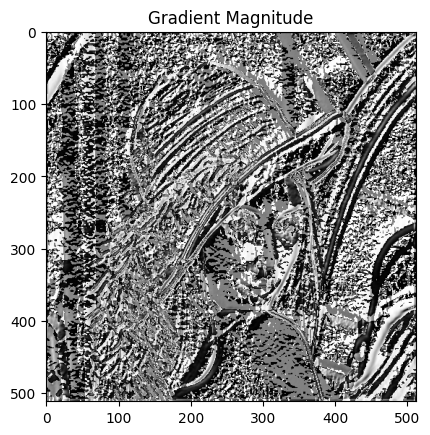

In [ ]:
plt.imshow(theta, cmap='gray')
plt.title("Gradient Magnitude")
plt.show()

In [ ]:
#the sobel filter Mx
filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
grad_mag, grad_dir = sobel_edge_detection(gaussian_filtered2, filter, convert_to_degree=True)
Image.fromarray(grad_mag.astype(np.uint8)).save('grad_mag_lena.png')
Image.fromarray(grad_dir.astype(np.uint8)).save('grad_dir_lena.png')

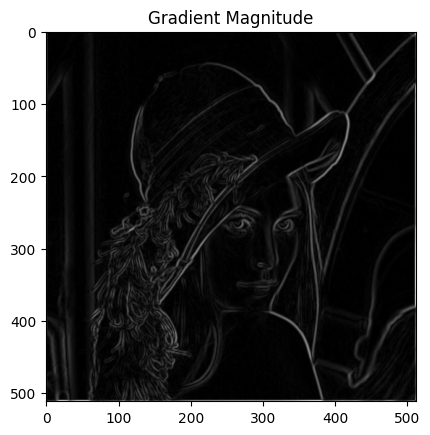

In [ ]:
#when you remove astype(np.uint8) from all functions, then you get a better gradient strength image
plt.imshow(grad_mag.astype(np.uint8), cmap='gray')
plt.title("Gradient Magnitude")
plt.show()

Text(0.5, 1.0, 'Gradient Magnitude Without Average in Convolution')

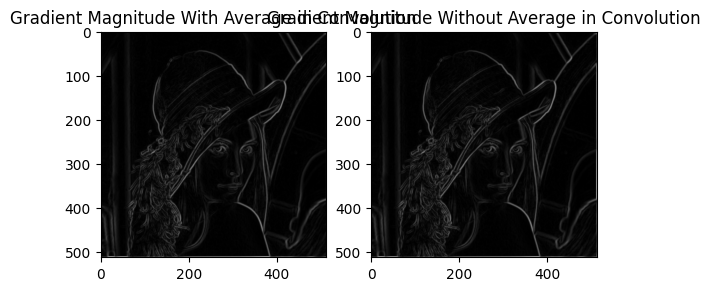

In [ ]:
#retry after removing average=True in all convolution functions
def sobel_edge_detection_woavg(image, filter, convert_to_degree=False):
  new_image_x = convolution(image, filter)
  new_image_y = convolution(image, np.flip(filter.T, axis=0))
  #combine both into 1 gradient image using sqrt of Gx**2 + Gy**2
  gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
  #normalize the output to be between 0 and 255
  gradient_magnitude *= 255.0 / gradient_magnitude.max()

  if convert_to_degree:
    gradient_direction = np.arctan2(new_image_y, new_image_x)
    gradient_direction = np.rad2deg(gradient_direction)
    gradient_direction += 180

  return gradient_magnitude, gradient_direction

gaus_filtered = convolution(gray_img, gaussian)
filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
grad_mag_woavg, grad_dir_woavg = sobel_edge_detection_woavg(gaus_filtered, filter, convert_to_degree=True)

plt.subplot(1, 2, 1)
plt.imshow(grad_mag.astype(np.uint8), cmap='gray')
plt.title("Gradient Magnitude With Average in Convolution")  # Set the title for the first image

# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(grad_mag_woavg.astype(np.uint8), cmap='gray')
plt.title("Gradient Magnitude Without Average in Convolution")  # Set the title for the second image

In [ ]:
def my_sobel_edge_detection(image, filter, convert_to_degree=False):
  new_image_x = convolution(image, filter) #, average=True
  new_image_y = convolution(image, np.flip(filter.T, axis=0)) #, average=True
  #combine both into 1 gradient image using sqrt of Gx**2 + Gy**2
  gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
  #normalize the output to be between 0 and 255
  gradient_magnitude *= 255.0 / gradient_magnitude.max()

  if convert_to_degree:
    #np.arctan2 returns angles in radians
    gradient_direction = np.arctan2(new_image_y, new_image_x)
    #convert radians to degrees
    gradient_direction = gradient_direction * 180 / np.pi
    #add 180 to the negative angles so that all angles are between 0 and 180
    gradient_direction[gradient_direction < 0] += 180

  return gradient_magnitude, gradient_direction

filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
grad_mag, grad_dir = sobel_edge_detection(gaussian_filtered, filter, convert_to_degree=True)

Text(0.5, 1.0, 'Gradient Direction')

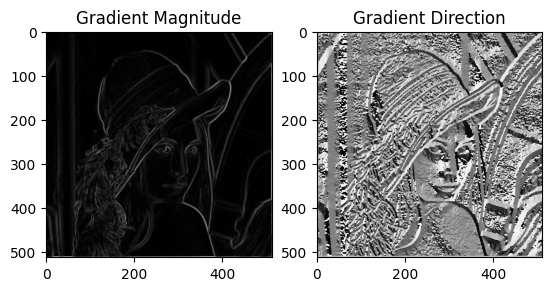

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(grad_mag.astype(np.uint8), cmap='gray')
plt.title("Gradient Magnitude")  # Set the title for the first image

# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(grad_dir, cmap='gray')
plt.title("Gradient Direction")

The discretization of directions is as follows:


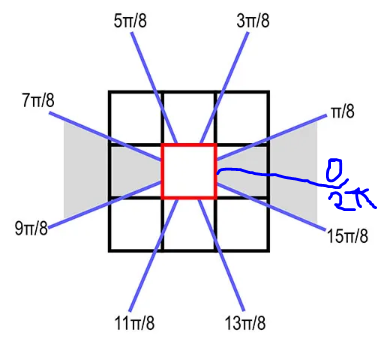

In [ ]:
#remove the redudant/duplicate edges identified by Sobel filters using Non-Max Suppression Algorithm
#we only need 1 line to indicate an edge
'''
We want to make sure no adjacent pixels are representing the same edge and in order to do that,
we want to compare the Magnitude of the gradient between one pixel and it’s neighboring pixels along the same direction
and select the pixel whose magnitude is the largest.
Refer to the following reference for more explanations:
https://www.adeveloperdiary.com/data-science/computer-vision/implement-canny-edge-detector-using-python-from-scratch/
'''
def non_max_suppression(gradient_magnitude, gradient_direction):
  image_row, image_col = gradient_magnitude.shape
  output = np.zeros(gradient_magnitude.shape)
  #set to PI to 180 degrees
  PI = 180
  #loop through all the pixels in the gradient directions ( except the border pixels )
  for row in range(1, image_row - 1):
    for col in range(1, image_col - 1):
        direction = gradient_direction[row, col]
        #based on the value of gradient direction store the gradient magnitude of the two neighboring pixel.
        if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI) or (7 * PI / 8 <= direction < 9 * PI / 8):
            before_pixel = gradient_magnitude[row, col - 1]
            after_pixel = gradient_magnitude[row, col + 1]
        elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
            before_pixel = gradient_magnitude[row + 1, col - 1]
            after_pixel = gradient_magnitude[row - 1, col + 1]
        elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
            before_pixel = gradient_magnitude[row - 1, col]
            after_pixel = gradient_magnitude[row + 1, col]
        else:
            before_pixel = gradient_magnitude[row - 1, col - 1]
            after_pixel = gradient_magnitude[row + 1, col + 1]
        # find out whether the selected/middle pixel has the highest gradient magnitude or not
        # if highest, update the output image for the given row and col with the value of the gradient magnitude
        if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
            output[row, col] = gradient_magnitude[row, col]
  return output

Text(0.5, 1.0, 'After Non Max Suppression')

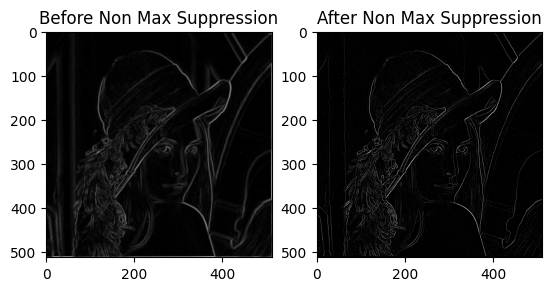

In [ ]:
nonmaxsup = non_max_suppression(grad_mag, grad_dir)

plt.subplot(1, 2, 1)
plt.imshow(grad_mag.astype(np.uint8), cmap='gray')
plt.title("Before Non Max Suppression")  # Set the title for the first image

# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(nonmaxsup, cmap='gray')
plt.title("After Non Max Suppression")  # Set the title for the second image

In [ ]:
#remove the redudant/duplicate edges identified by Sobel filters using Non-Max Suppression Algorithm
#we only need 1 line to indicate an edge
def my_non_max_suppression(gradient_magnitude, gradient_direction):
  image_row, image_col = gradient_magnitude.shape
  output = np.zeros(gradient_magnitude.shape)
  #set to PI to 180 degrees
  PI = 180
  #loop through all the pixels in the gradient directions ( except the border pixels )
  for row in range(1, image_row - 1):
    for col in range(1, image_col - 1):
        direction = gradient_direction[row, col]
        #based on the value of gradient direction store the gradient magnitude of the two neighboring pixel.
        if (0 <= direction < PI / 8) or (7 * PI / 8 <= direction <= PI):
            before_pixel = gradient_magnitude[row, col - 1]
            after_pixel = gradient_magnitude[row, col + 1]
        elif (PI / 8 <= direction < 3 * PI / 8):
            before_pixel = gradient_magnitude[row + 1, col - 1]
            after_pixel = gradient_magnitude[row - 1, col + 1]
        elif (3 * PI / 8 <= direction < 5 * PI / 8):
            before_pixel = gradient_magnitude[row - 1, col]
            after_pixel = gradient_magnitude[row + 1, col]
        else:
            before_pixel = gradient_magnitude[row - 1, col - 1]
            after_pixel = gradient_magnitude[row + 1, col + 1]
        # find out whether the selected/middle pixel has the highest gradient magnitude or not
        # if highest, update the output image for the given row and col with the value of the gradient magnitude
        if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
            output[row, col] = gradient_magnitude[row, col]
  return output

Text(0.5, 1.0, 'After Non Max Suppression')

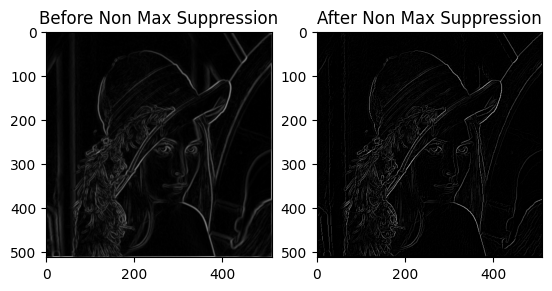

In [ ]:
nonmaxsup = my_non_max_suppression(grad_mag, grad_dir)

plt.subplot(1, 2, 1)
plt.imshow(grad_mag.astype(np.uint8), cmap='gray')
plt.title("Before Non Max Suppression")  # Set the title for the first image

# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(nonmaxsup, cmap='gray')
plt.title("After Non Max Suppression")  # Set the title for the second image

Text(0.5, 1.0, 'After Double Thresholding')

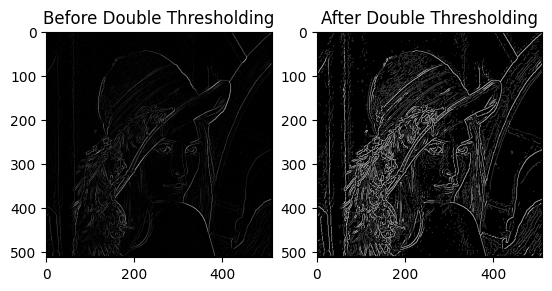

In [ ]:
#there are still some edges between gray to dark-gray
#objective is to produce clear edges ( all the edge pixel will be 255 ) using Hysteresis Threshold
#has 2 parts: apply thresholding & apply hysteresis

#for thresholding take all the edges and define them either weak (some low number say 50) or strong ( white –> 255 )
def threshold(image, low, high, weak):
  output = np.zeros(image.shape)
  strong = 255
  strong_row, strong_col = np.where(image >= high)
  weak_row, weak_col = np.where((image <= high) & (image >= low))
  output[strong_row, strong_col] = strong
  output[weak_row, weak_col] = weak
  return output

weak = 100
doublethresh = threshold(nonmaxsup, 5, 20, weak=weak)
plt.subplot(1, 2, 1)
plt.imshow(nonmaxsup.astype(np.uint8), cmap='gray')
plt.title("Before Double Thresholding")
# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(doublethresh, cmap='gray')
plt.title("After Double Thresholding")

In [ ]:
print(f'High Threshold: - {nonmaxsup.max()*0.09}')
print(f'Low Threshold: - {nonmaxsup.max()*0.09 * 0.05}')

High Threshold: - 12.946220372383037
Low Threshold: - 0.6473110186191519


In [ ]:
12.946220372383037/0.09

143.8468930264782

Text(0.5, 1.0, 'After Double Thresholding')

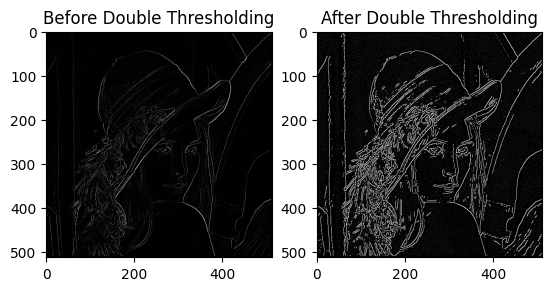

In [ ]:
def threshold2(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
  highThreshold = img.max() * highThresholdRatio
  lowThreshold = highThreshold * lowThresholdRatio
  M, N = img.shape
  res = np.zeros((M,N), dtype=np.uint8)
  weak = np.uint8(25)
  strong = np.uint8(255)
  strong_i, strong_j = np.where(img >= highThreshold)
  zeros_i, zeros_j = np.where(img < lowThreshold)
  weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak
  return res

doublethresh2 = threshold2(nonmaxsup)
plt.subplot(1, 2, 1)
plt.imshow(nonmaxsup.astype(np.uint8), cmap='gray')
plt.title("Before Double Thresholding")
# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(doublethresh2, cmap='gray')
plt.title("After Double Thresholding")

Text(0.5, 1.0, 'Double Thresholding 2')

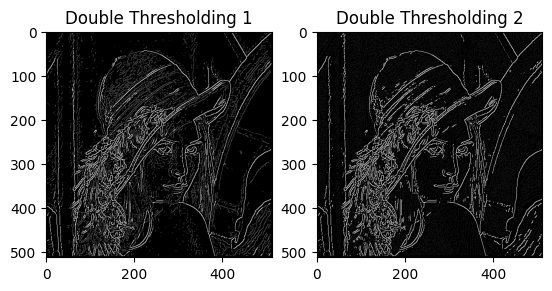

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(doublethresh.astype(np.uint8), cmap='gray')
plt.title("Double Thresholding 1")
# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(doublethresh2, cmap='gray')
plt.title("Double Thresholding 2")

Text(0.5, 1.0, 'Edge Image for Double Thresholding2')

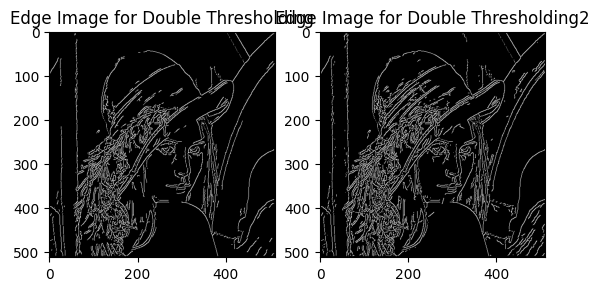

In [ ]:
#objective of the hysteresis function is to identify the weak pixels which can be edges and discard the remaining
#find out whether a selected pixel is connected to the already defined edge pixels
#if so we can consider this pixel also to be part of an edge
#find out whether any given pixels neighbors ( as we have seen earlier, there will be total 8 ) has value equal to 255,
#if yes then change the value of the pixel to 255, otherwise discard the pixel by setting the value to 0.

def hysteresis(image, weak):
  image_row, image_col = image.shape
  for row in range(1, image_row):
    for col in range(1, image_col):
      if image[row, col] == weak:
        if (image[row, col + 1] == 255 or
            image[row, col - 1] == 255 or
            image[row - 1, col] == 255 or
            image[row + 1, col] == 255 or
            image[row - 1, col - 1] == 255 or
            image[row + 1, col - 1] == 255 or
            image[row - 1, col + 1] == 255 or
            image[row + 1, col + 1] == 255):
          image[row, col] = 255
        else:
          image[row, col] = 0
  return image

finaledge = hysteresis(doublethresh, 100)
finaledge2 = hysteresis(doublethresh2, 25)
plt.subplot(1, 2, 1)
plt.imshow(finaledge.astype(np.uint8), cmap='gray')
plt.title("Edge Image for Double Thresholding")
# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(finaledge2, cmap='gray')
plt.title("Edge Image for Double Thresholding2")

In [ ]:
def hysteresis2(image, weak):
    image_row, image_col = image.shape

    top_to_bottom = image.copy()

    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak:
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0

    bottom_to_top = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0

    right_to_left = image.copy()

    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0

    left_to_right = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0

    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right

    final_image[final_image > 255] = 255

    return final_image

Text(0.5, 1.0, 'Hysteresis 2')

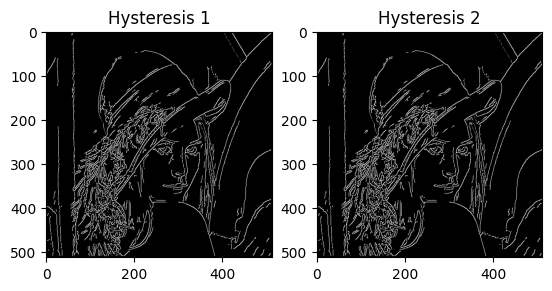

In [ ]:
finaledge3 = hysteresis2(doublethresh, 100)
plt.subplot(1, 2, 1)
plt.imshow(finaledge.astype(np.uint8), cmap='gray')
plt.title("Hysteresis 1")
# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(finaledge3, cmap='gray')
plt.title("Hysteresis 2")

In [ ]:
def hysteresis3(image, weak, row_loop, col_loop):
  row_start, row_end, row_step = row_loop
  col_start, col_end, col_step = col_loop
  for row in range(row_start, row_end, row_step):
    for col in range(col_start, col_end, col_step):
      if image[row, col] == weak:
        if (image[row, col + 1] == 255 or
            image[row, col - 1] == 255 or
            image[row - 1, col] == 255 or
            image[row + 1, col] == 255 or
            image[row - 1, col - 1] == 255 or
            image[row + 1, col - 1] == 255 or
            image[row - 1, col + 1] == 255 or
            image[row + 1, col + 1] == 255):
          image[row, col] = 255
        else:
          image[row, col] = 0

def get_final_edge_image(image, weak):
  image_row, image_col = image.shape

  top_to_bottom = image.copy()
  hysteresis3(top_to_bottom, weak, (1, image_row, 1), (1, image_col, 1))
  bottom_to_top = image.copy()
  hysteresis3(bottom_to_top, weak, (image_row - 1, 0, -1), (image_col - 1, 0, -1))
  right_to_left = image.copy()
  hysteresis3(right_to_left, weak, (1, image_row, 1), (image_col - 1, 0, -1))
  left_to_right = image.copy()
  hysteresis3(left_to_right, weak, (image_row - 1, 0, -1), (1, image_col, 1))

  final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right
  final_image[final_image > 255] = 255
  return final_image

Text(0.5, 1.0, 'My Method')

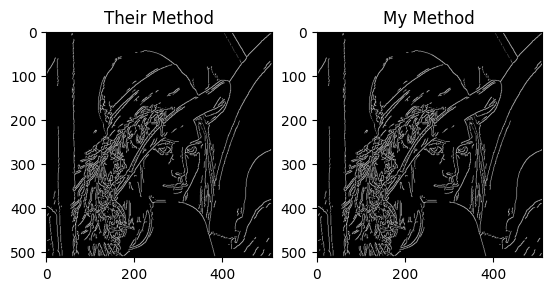

In [ ]:
finaledge4 = get_final_edge_image(doublethresh, 100)
plt.subplot(1, 2, 1)
plt.imshow(finaledge3, cmap='gray')
plt.title("Their Method")
# Second subplot (right side)
plt.subplot(1, 2, 2)
plt.imshow(finaledge4, cmap='gray')
plt.title("My Method")

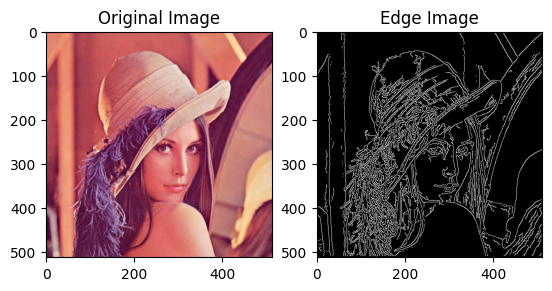

In [ ]:
import cv2
import numpy as np
from PIL import Image

def convert_to_grayscale(image):
  grayscale_image = np.zeros((image.shape[0], image.shape[1]), np.uint8)
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      r, g, b = image[x][y]
      #weighted contributions of red, green and blue channels
      gray_value = 0.299 * r + 0.587 * g + 0.114 * b
      grayscale_image[x][y] = gray_value
  return grayscale_image

'''
K(x, y) = (1 / (2 * pi * sigma^2)) * exp(-((i-k-1)^2 + (j-k-1)^2) / (2 * sigma^2)), where i,j range from 1 to size,
and k = size//2
'''
def gaussian_kernel(size, sigma=1):
  x, y = np.mgrid[1:size+1, 1:size+1]
  k = size//2
  normal = 1 / (2.0 * np.pi * sigma**2)
  expterm = np.exp(-(((x-k-1)**2 + (y-k-1)**2) / (2.0*sigma**2)))
  gaussian = normal * expterm
  return gaussian

'''
For output to be in same dimension as input (i.e. same convolution), need to pad the image
Here pad the image with 0s
The size of padding is given by (k-1)/2 where k is the size of kernel
'''
def convolution(image, kernel):
  image_row, image_col = image.shape
  kernel_row, kernel_col = kernel.shape

  output = np.zeros(image.shape)

  pad_height = int((kernel_row - 1) / 2)
  pad_width = int((kernel_col - 1) / 2)
  padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
  padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

  for row in range(image_row):
    for col in range(image_col):
        output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])

  return output

def sobel_edge_detection(image, filter, convert_to_degree=False):
  new_image_x = convolution(image, filter)
  new_image_y = convolution(image, np.flip(filter.T, axis=0))
  #combine both into 1 gradient image using sqrt of Gx**2 + Gy**2
  gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
  #normalize the output to be between 0 and 255
  gradient_magnitude *= 255.0 / gradient_magnitude.max()
  #np.arctan2 returns angles in radians
  gradient_direction = np.arctan2(new_image_y, new_image_x)

  if convert_to_degree:
    #convert radians to degrees
    gradient_direction = gradient_direction * 180 / np.pi
    #add 180 to the negative angles so that all angles are between 0 and 180
    gradient_direction[gradient_direction < 0] += 180

  return gradient_magnitude, gradient_direction

'''
remove the redudant/duplicate edges identified by Sobel filters using Non-Max Suppression Algorithm
'''
def non_max_suppression(gradient_magnitude, gradient_direction):
  image_row, image_col = gradient_magnitude.shape
  output = np.zeros(gradient_magnitude.shape)
  #set to PI to 180 degrees
  PI = 180
  #loop through all the pixels in the gradient directions ( except the border pixels )
  for row in range(1, image_row - 1):
    for col in range(1, image_col - 1):
        direction = gradient_direction[row, col]
        #based on the value of gradient direction store the gradient magnitude of the two neighboring pixel.
        if (0 <= direction < PI / 8) or (7 * PI / 8 <= direction <= PI):
            before_pixel = gradient_magnitude[row, col - 1]
            after_pixel = gradient_magnitude[row, col + 1]
        elif (PI / 8 <= direction < 3 * PI / 8):
            before_pixel = gradient_magnitude[row + 1, col - 1]
            after_pixel = gradient_magnitude[row - 1, col + 1]
        elif (3 * PI / 8 <= direction < 5 * PI / 8):
            before_pixel = gradient_magnitude[row - 1, col]
            after_pixel = gradient_magnitude[row + 1, col]
        else:
            before_pixel = gradient_magnitude[row - 1, col - 1]
            after_pixel = gradient_magnitude[row + 1, col + 1]
        # find out whether the selected/middle pixel has the highest gradient magnitude or not
        # if highest, update the output image for the given row and col with the value of the gradient magnitude
        if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
            output[row, col] = gradient_magnitude[row, col]
  return output

'''
there are still some edges between gray to dark-gray
objective is to produce clear edges ( all the edge pixel will be 255 ) using Hysteresis Threshold
has 2 parts: apply thresholding & apply hysteresis

thresholding takes all the edges, defines them as
weak (say intensity value 25) or strong (intensity value 255) or irrelevant (intensity value 0)
'''
def double_thresholding(img, weak, lowThresholdRatio=0.05, highThresholdRatio=0.09):
  highThreshold = img.max() * highThresholdRatio
  lowThreshold = highThreshold * lowThresholdRatio
  M, N = img.shape
  result = np.zeros((M,N), dtype=np.uint8)
  strong = np.uint8(255)
  strong_row, strong_col = np.where(img >= highThreshold)
  weak_row, weak_col = np.where((img <= highThreshold) & (img >= lowThreshold))
  result[strong_row, strong_col] = strong
  result[weak_row, weak_col] = weak
  return result

'''
objective of the hysteresis function is to identify the weak pixels which can be edges and discard the remaining
find out whether a selected weak pixel is connected to the already defined edge pixels
if so can consider this weak pixel also to be part of an edge
so find out whether any of the 8 neighbor pixels has value equal to 255,
if yes then change the value of the weak pixel to 255, otherwise make it irrelevant by changing the value to 0
'''
def hysteresis(image, weak, row_loop, col_loop):
  row_start, row_end, row_step = row_loop
  col_start, col_end, col_step = col_loop
  for row in range(row_start, row_end, row_step):
    for col in range(col_start, col_end, col_step):
      if image[row, col] == weak:
        if (image[row, col + 1] == 255 or
            image[row, col - 1] == 255 or
            image[row - 1, col] == 255 or
            image[row + 1, col] == 255 or
            image[row - 1, col - 1] == 255 or
            image[row + 1, col - 1] == 255 or
            image[row - 1, col + 1] == 255 or
            image[row + 1, col + 1] == 255):
          image[row, col] = 255
        else:
          image[row, col] = 0

def get_final_edge_image(image, weak):
  image_row, image_col = image.shape

  #hysteresis while scanning the image from top-left to bottom-right corner
  top_to_bottom = image.copy()
  hysteresis(top_to_bottom, weak, (1, image_row, 1), (1, image_col, 1))
  #hysteresis while scanning the image from bottom-right to top-left corner
  bottom_to_top = image.copy()
  hysteresis(bottom_to_top, weak, (image_row - 1, 0, -1), (image_col - 1, 0, -1))
  #hysteresis while scanning the image from top-right to bottom-left corner
  right_to_left = image.copy()
  hysteresis(right_to_left, weak, (1, image_row, 1), (image_col - 1, 0, -1))
  #hysteresis while scanning the image from bottom-left to top-right corner
  left_to_right = image.copy()
  hysteresis(left_to_right, weak, (image_row - 1, 0, -1), (1, image_col, 1))

  #Sum all the pixels to create final image and threshold to 255
  final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right
  final_image[final_image > 255] = 255
  return final_image

def visualize(original_img, edge_img):
  plt.subplot(1, 2, 1)
  plt.imshow(original_img)
  plt.title("Original Image")
  # Second subplot (right side)
  plt.subplot(1, 2, 2)
  plt.imshow(edge_img, cmap='gray')
  plt.title("Edge Image")

img = Image.open('lena.png')
img = np.array(img)
gray_img = convert_to_grayscale(img)
#using a gaussian kernel of 5x5 size
gaus_kernel = gaussian_kernel(5)
gaus_filtered_img = convolution(gray_img, gaus_kernel)
sobel_filter_mx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
grad_mag, grad_dir = sobel_edge_detection(gaus_filtered_img, sobel_filter_mx, convert_to_degree=True)
non_max_suppressed_img = non_max_suppression(grad_mag, grad_dir)
weak = np.uint8(25) #intensity value chosen for weak pixels
thresholded_img = double_thresholding(non_max_suppressed_img, weak)
edge_img = get_final_edge_image(thresholded_img, weak)
Image.fromarray(edge_img).save('edge_image.png')
visualize(img, edge_img)

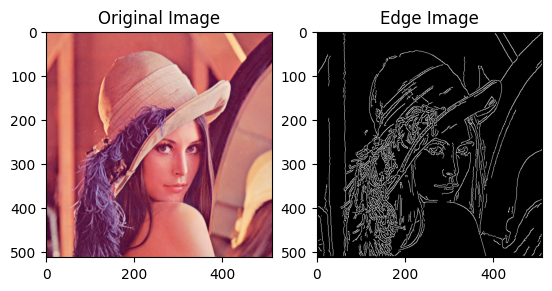

In [ ]:
import cv2
import numpy as np
from PIL import Image

def convert_to_grayscale(image):
  grayscale_image = np.zeros((image.shape[0], image.shape[1]), np.uint8)
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      r, g, b = image[x][y]
      #weighted contributions of red, green and blue channels
      gray_value = 0.299 * r + 0.587 * g + 0.114 * b
      grayscale_image[x][y] = gray_value
  return grayscale_image

'''
K(x, y) = (1 / (2 * pi * sigma^2)) * exp(-((i-k-1)^2 + (j-k-1)^2) / (2 * sigma^2)), where i,j range from 1 to size,
and k = size//2
'''
def gaussian_kernel(size, sigma=1):
  x, y = np.mgrid[1:size+1, 1:size+1]
  k = size//2
  normal = 1 / (2.0 * np.pi * sigma**2)
  expterm = np.exp(-(((x-k-1)**2 + (y-k-1)**2) / (2.0*sigma**2)))
  gaussian = normal * expterm
  return gaussian

'''
For output to be in same dimension as input (i.e. same convolution), need to pad the image
Here pad the image with 0s
The size of padding is given by (k-1)/2 where k is the size of kernel
'''
def convolution(image, kernel):
  image_row, image_col = image.shape
  kernel_row, kernel_col = kernel.shape

  output = np.zeros(image.shape)

  pad_height = int((kernel_row - 1) / 2)
  pad_width = int((kernel_col - 1) / 2)
  padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
  padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

  for row in range(image_row):
    for col in range(image_col):
        output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])

  return output

def sobel_edge_detection(image, filter, convert_to_degree=False):
  new_image_x = convolution(image, filter)
  new_image_y = convolution(image, np.flip(filter.T, axis=0))
  #combine both into 1 gradient image using sqrt of Gx**2 + Gy**2
  gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
  #normalize the output to be between 0 and 255
  gradient_magnitude *= 255.0 / gradient_magnitude.max()
  #np.arctan2 returns angles in radians
  gradient_direction = np.arctan2(new_image_y, new_image_x)

  if convert_to_degree:
    #convert radians to degrees
    gradient_direction = gradient_direction * 180 / np.pi
    #add 180 to the negative angles so that all angles are between 0 and 180
    gradient_direction[gradient_direction < 0] += 180

  return gradient_magnitude, gradient_direction

'''
remove the redudant/duplicate edges identified by Sobel filters using Non-Max Suppression Algorithm
'''
def non_max_suppression(gradient_magnitude, gradient_direction):
  image_row, image_col = gradient_magnitude.shape
  output = np.zeros(gradient_magnitude.shape)
  #set to PI to 180 degrees
  PI = 180
  #loop through all the pixels in the gradient directions ( except the border pixels )
  for row in range(1, image_row - 1):
    for col in range(1, image_col - 1):
        direction = gradient_direction[row, col]
        #based on the value of gradient direction store the gradient magnitude of the two neighboring pixel.
        if (0 <= direction < PI / 8) or (7 * PI / 8 <= direction <= PI):
            before_pixel = gradient_magnitude[row, col - 1]
            after_pixel = gradient_magnitude[row, col + 1]
        elif (PI / 8 <= direction < 3 * PI / 8):
            before_pixel = gradient_magnitude[row + 1, col - 1]
            after_pixel = gradient_magnitude[row - 1, col + 1]
        elif (3 * PI / 8 <= direction < 5 * PI / 8):
            before_pixel = gradient_magnitude[row - 1, col]
            after_pixel = gradient_magnitude[row + 1, col]
        else:
            before_pixel = gradient_magnitude[row - 1, col - 1]
            after_pixel = gradient_magnitude[row + 1, col + 1]
        # find out whether the selected/middle pixel has the highest gradient magnitude or not
        # if highest, update the output image for the given row and col with the value of the gradient magnitude
        if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
            output[row, col] = gradient_magnitude[row, col]
  return output

'''
there are still some edges between gray to dark-gray
objective is to produce clear edges ( all the edge pixel will be 255 ) using Hysteresis Threshold
has 2 parts: apply thresholding & apply hysteresis

thresholding takes all the edges, defines them as
weak (say intensity value 25) or strong (intensity value 255) or irrelevant (intensity value 0)
'''
def double_thresholding(image, low_threshold, high_threshold, weak):
  output = np.zeros(image.shape, dtype=np.uint8)
  strong = np.uint8(255)
  strong_row, strong_col = np.where(image >= high_threshold)
  weak_row, weak_col = np.where((image <= high_threshold) & (image >= low_threshold))
  output[strong_row, strong_col] = strong
  output[weak_row, weak_col] = weak
  return output

'''
objective of the hysteresis function is to identify the weak pixels which can be edges and discard the remaining
find out whether a selected weak pixel is connected to the already defined edge pixels
if so can consider this weak pixel also to be part of an edge
so find out whether any of the 8 neighbor pixels has value equal to 255,
if yes then change the value of the weak pixel to 255, otherwise make it irrelevant by changing the value to 0
'''
def hysteresis(image, weak, row_loop, col_loop):
  row_start, row_end, row_step = row_loop
  col_start, col_end, col_step = col_loop
  for row in range(row_start, row_end, row_step):
    for col in range(col_start, col_end, col_step):
      if image[row, col] == weak:
        if (image[row, col + 1] == 255 or
            image[row, col - 1] == 255 or
            image[row - 1, col] == 255 or
            image[row + 1, col] == 255 or
            image[row - 1, col - 1] == 255 or
            image[row + 1, col - 1] == 255 or
            image[row - 1, col + 1] == 255 or
            image[row + 1, col + 1] == 255):
          image[row, col] = 255
        else:
          image[row, col] = 0

'''
hysteresis from all 4 corners of the image to avoid edge discontinuities
'''
def get_final_edge_image(image, weak):
  image_row, image_col = image.shape
  #hysteresis while scanning the image from top-left to bottom-right corner
  top_to_bottom = image.copy()
  hysteresis(top_to_bottom, weak, (1, image_row, 1), (1, image_col, 1))
  #hysteresis while scanning the image from bottom-right to top-left corner
  bottom_to_top = image.copy()
  hysteresis(bottom_to_top, weak, (image_row - 1, 0, -1), (image_col - 1, 0, -1))
  #hysteresis while scanning the image from top-right to bottom-left corner
  right_to_left = image.copy()
  hysteresis(right_to_left, weak, (1, image_row, 1), (image_col - 1, 0, -1))
  #hysteresis while scanning the image from bottom-left to top-right corner
  left_to_right = image.copy()
  hysteresis(left_to_right, weak, (image_row - 1, 0, -1), (1, image_col, 1))

  #Sum all the pixels to create final image and threshold to 255
  final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right
  final_image[final_image > 255] = 255
  return final_image

def visualize(original_img, edge_img):
  plt.subplot(1, 2, 1)
  plt.imshow(original_img)
  plt.title("Original Image")
  # Second subplot (right side)
  plt.subplot(1, 2, 2)
  plt.imshow(edge_img, cmap='gray')
  plt.title("Edge Image")

def canny_edge_detection(image_path, save_path, low_threshold, high_threshold, gaussian_kernel_size):
  img = Image.open(image_path)
  img = np.array(img)
  gray_img = convert_to_grayscale(img)
  #using a gaussian kernel of 5x5 size
  gaus_kernel = gaussian_kernel(gaussian_kernel_size)
  gaus_filtered_img = convolution(gray_img, gaus_kernel)
  sobel_filter_mx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  grad_mag, grad_dir = sobel_edge_detection(gaus_filtered_img, sobel_filter_mx, convert_to_degree=True)
  non_max_suppressed_img = non_max_suppression(grad_mag, grad_dir)
  weak = np.uint8(25) #intensity value chosen for weak pixels
  thresholded_img = double_thresholding(non_max_suppressed_img, low_threshold, high_threshold, weak)
  edge_img = get_final_edge_image(thresholded_img, weak)
  visualize(img, edge_img)
  Image.fromarray(edge_img).save(save_path)

canny_edge_detection('lena.png', 'edge_image_10_20.png', 10, 20, 5)

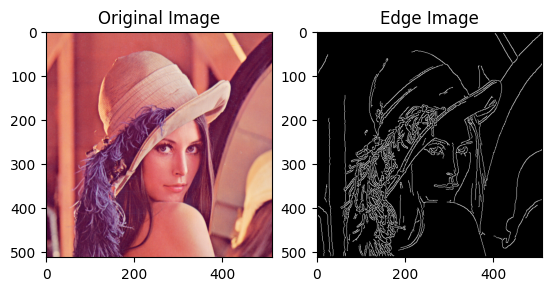

In [ ]:
canny_edge_detection('lena.png', 'edge_image_10_30.png', 10, 30, 5)

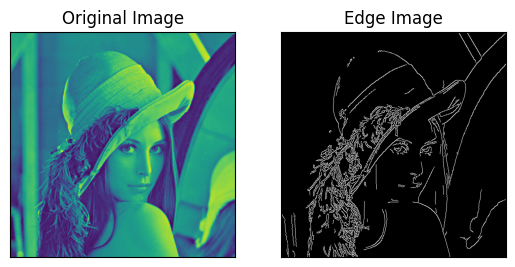

In [ ]:
import cv2

img = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(img,100,200) #100,200
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()